In [1]:
import numpy as np
df=np.load("/Users/rohitviswam/Downloads/CSI-02-0005/H_32T4R_30_1RB.npy")
data=df.reshape(2100,398,256)
data.shape
feature_len=data.shape[-1]

In [2]:
data.shape

(2100, 398, 256)

In [3]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [4]:
data_flattened = data.reshape(data.shape[0], -1)  # shape becomes (2100, 398*256)


In [5]:
data = data_flattened

In [6]:
# Parameters
n_samples = 2100
n_timesteps = 398 * 256
input_window = 10  # First 10 values are used as input
output_window = 4  # Next 4 values are predicted
test_size = 0.2  # 20% of the data is used for testing

# Initialize lists to hold models and predictions/actuals for each UE
models = []
predictions = []
actuals = []

In [7]:
for ue in range(n_samples):
    # Extract data for this specific UE
    ue_data = data[ue, :]  # Shape: (n_timesteps,)
    
    # Create input-output pairs (input sequences and targets)
    X_ue = []
    y_ue = []
    
    for i in range(0, len(ue_data) - input_window - output_window + 1, input_window):
        # Use the current window for input
        X_ue.append(ue_data[i:i + input_window])
        # Predict the next 4 values immediately following the current window
        y_ue.append(ue_data[i + input_window:i + input_window + output_window])

    # Convert to NumPy arrays
    X_ue = np.array(X_ue)
    y_ue = np.array(y_ue)
    
    # Flatten the target array to make it compatible with XGBoost
    y_ue = y_ue.reshape((y_ue.shape[0], -1))  # (n_samples, output_window)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_ue, y_ue, test_size=test_size, random_state=42)

    # Initialize the XGBoost model
    model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, objective='reg:squarederror')
    
    # Train the model on the training set
    model.fit(X_train, y_train)
    
    # Make predictions on the testing set
    y_pred = model.predict(X_test)
    
    # Save the predictions and actuals for evaluation
    predictions.append(y_pred)
    actuals.append(y_test)
    
    # Save the model for this UE
    models.append(model)

In [8]:
import pandas as pd

# Initialize a list to store DataFrames for each UE
all_results = []

# Iterate through the predictions and actuals stored previously
for ue_index, (y_pred, y_test) in enumerate(zip(predictions, actuals)):
    # Reshape predictions and actuals for ease of comparison
    y_pred_reshaped = y_pred.reshape(-1, output_window)
    y_test_reshaped = y_test.reshape(-1, output_window)
    
    # Create a DataFrame for this UE's predictions and actuals
    results_df = pd.DataFrame({
        "Actual_1": y_test_reshaped[:, 0],
        "Actual_2": y_test_reshaped[:, 1],
        "Actual_3": y_test_reshaped[:, 2],
        "Actual_4": y_test_reshaped[:, 3],
        "Predicted_1": y_pred_reshaped[:, 0],
        "Predicted_2": y_pred_reshaped[:, 1],
        "Predicted_3": y_pred_reshaped[:, 2],
        "Predicted_4": y_pred_reshaped[:, 3]
    })
    
    # Add an identifier for each UE
    results_df["UE"] = f"UE_{ue_index + 1}"
    
    # Append to the list of DataFrames
    all_results.append(results_df)

# Concatenate all DataFrames into one
final_results = pd.concat(all_results, ignore_index=True)

# Display the combined table
print(final_results)


         Actual_1  Actual_2  Actual_3  Actual_4  Predicted_1  Predicted_2  \
0       -0.781295 -0.969110  0.396421  0.463016    -0.551291    -0.853132   
1        0.636567  0.042505  0.353931  0.577305     0.846954    -0.221120   
2       -1.029850 -0.441041  0.473300 -0.512002    -0.880720    -0.242621   
3       -0.472827 -0.966629 -0.060249  0.787439    -0.268060    -0.720368   
4       -0.383845  0.976808 -0.940861 -0.629509    -0.738029     0.587662   
...           ...       ...       ...       ...          ...          ...   
4279795 -0.923270  0.356513  1.035430  0.331961    -0.965402     0.297534   
4279796  1.018100  0.257734  0.357409 -0.579033     0.931537     0.536266   
4279797 -0.852918  0.729973  0.977082  0.646676    -0.538595     0.764831   
4279798  0.755552  0.747230  0.999557 -0.701317     0.639914     0.911246   
4279799 -0.146493 -1.136730 -1.122710  0.095925    -0.506193    -0.844062   

         Predicted_3  Predicted_4       UE  
0           0.424527     0.631

In [9]:
import matplotlib.pyplot as plt

def visualize_ue_predictions(ue_index):
    """Visualize actual vs. predicted values for a specific UE."""
    if ue_index < 0 or ue_index >= len(predictions):
        raise ValueError("Invalid UE index")
    
    # Retrieve the actual and predicted values for the given UE index
    y_pred = predictions[ue_index]
    y_test = actuals[ue_index]

    # Prepare for visualization by creating indices
    num_predictions = y_test.shape[0]
    indices = range(num_predictions)

    plt.figure(figsize=(12, 6))
    
    # Plot each predicted value against its corresponding actual value
    for i in range(output_window):
        plt.plot(indices, y_test[:, i], marker='o', label=f'Actual_{i+1}')
        plt.plot(indices, y_pred[:, i], marker='x', linestyle='--', label=f'Predicted_{i+1}')
    
    plt.title(f"Actual vs. Predicted Values for UE {ue_index + 1}")
    plt.xlabel("Index")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)
    plt.show()


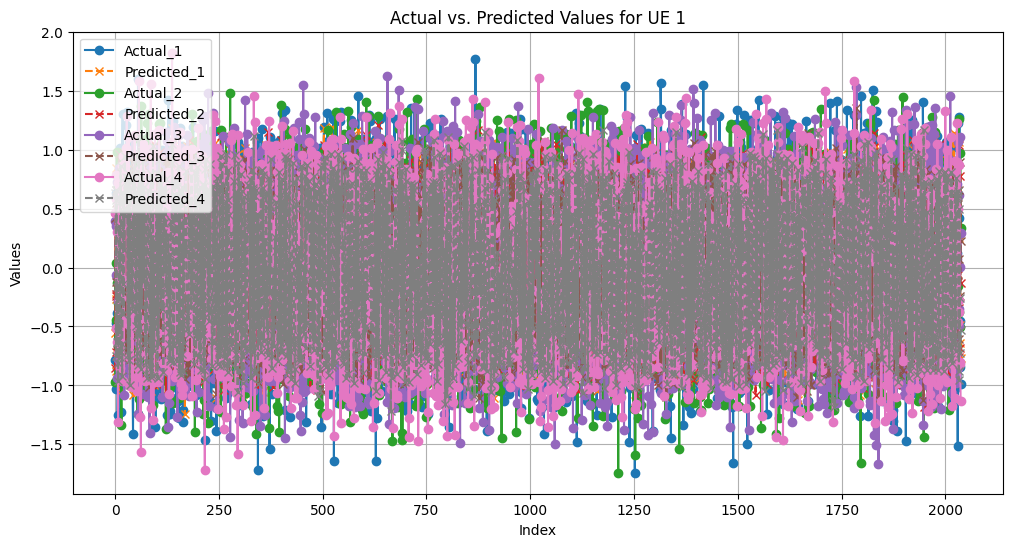

In [10]:
# Example usage: Visualize results for the first UE (index 0)
visualize_ue_predictions(0)

In [11]:
import matplotlib.pyplot as plt

def visualize_ue_predictions_with_range(ue_index, num_values):
    """Visualize actual vs. predicted values for a specific UE, limited to the first num_values entries."""
    if ue_index < 0 or ue_index >= len(predictions):
        raise ValueError("Invalid UE index")
    
    # Retrieve the actual and predicted values for the given UE index
    y_pred = predictions[ue_index]
    y_test = actuals[ue_index]

    # Ensure not to exceed the number of available predictions
    num_values = min(num_values, y_pred.shape[0])

    # Prepare for visualization by creating indices
    indices = range(num_values)

    plt.figure(figsize=(12, 6))
    
    # Plot each predicted value against its corresponding actual value for the first num_values
    for i in range(output_window):
        plt.plot(indices, y_test[:num_values, i], marker='o', label=f'Actual_{i+1}')
        plt.plot(indices, y_pred[:num_values, i], marker='x', linestyle='--', label=f'Predicted_{i+1}')
    
    plt.title(f"Actual vs. Predicted Values for UE {ue_index + 1} - First {num_values} Points")
    plt.xlabel("Index")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)
    plt.show()



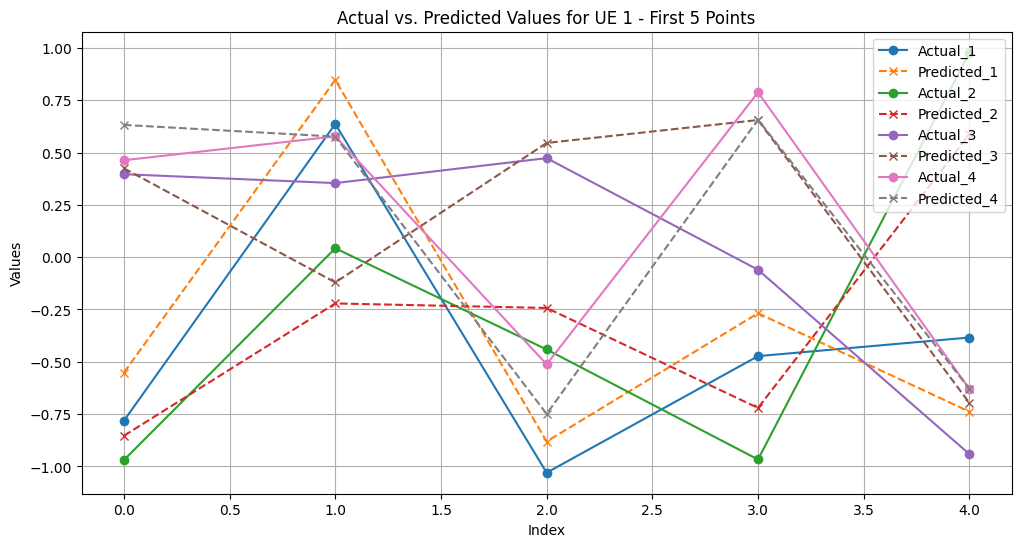

In [12]:
# Example usage: Visualize results for the first UE (index 0) and the first 20 data points
visualize_ue_predictions_with_range(0, 5)

In [13]:
# Optionally save to a CSV file for further analysis
final_results.to_csv("ue_predictions_comparison-10->4.csv", index=False)

In [17]:
# Assuming X_test and y_test are your test datasets
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

RMSE:  0.26813794158769005


In [23]:
import numpy as np

# Assuming y contains your target variable values
min_value = np.min(y_ue)
max_value = np.max(y_ue)

print("Minimum Value:", min_value)
print("Maximum Value:", max_value)

Minimum Value: -1.55654
Maximum Value: 1.51841


In [24]:
accuracy = 100- (rmse /( max_value-min_value)) * 100

In [25]:
accuracy

91.27992515040278